In [93]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: True
GPU: Tesla T4


In [94]:
!pip install -q transformers torch scikit-learn pandas tqdm spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 133.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [95]:
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    BertTokenizer, BertModel
)

from sklearn.metrics import accuracy_score
from tqdm import tqdm


In [96]:
from google.colab import drive
drive.mount('/content/drive')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/AI-AAT


In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [98]:
# Laptop
laptop_train = pd.read_csv("/content/drive/My Drive/AI-AAT/Laptop_Train_v2.csv")
laptop_testA = pd.read_csv("/content/drive/My Drive/AI-AAT/Laptops_Test_Data_PhaseA.csv")
laptop_testB = pd.read_csv("/content/drive/My Drive/AI-AAT/Laptops_Test_Data_PhaseB.csv")

# Restaurant
restaurant_train = pd.read_csv("/content/drive/My Drive/AI-AAT/Restaurants_Train_v2.csv")
restaurant_testA = pd.read_csv("/content/drive/My Drive/AI-AAT/Restaurants_Test_Data_PhaseA.csv")
restaurant_testB = pd.read_csv("/content/drive/My Drive/AI-AAT/Restaurants_Test_Data_PhaseB.csv")

print("Laptop train shape:", laptop_train.shape)
print("Restaurant train shape:", restaurant_train.shape)

Laptop train shape: (2358, 6)
Restaurant train shape: (3693, 6)


In [99]:
laptop_train.head()

,id,Sentence,Aspect Term,polarity,from,to
0,2339,I charge it at night and skip taking the cord ...,cord,neutral,41,45
1,2339,I charge it at night and skip taking the cord ...,battery life,positive,74,86
2,1316,The tech guy then said the service center does...,service center,negative,27,41
3,1316,The tech guy then said the service center does...,"""sales"" team",negative,109,121
4,1316,The tech guy then said the service center does...,tech guy,neutral,4,12


In [100]:
label2id = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

id2label = {v: k for k, v in label2id.items()}


In [101]:
def build_prompt(sentence, aspect):
    return f"{sentence} [SSEP] emotion of {aspect} : <extra_id_0>"

In [102]:
class ABSADataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = build_prompt(row["sentence"], row["aspect_term"])
        label = label2id[row["sentiment"].lower()]

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "label": torch.tensor(label)
        }

In [103]:
t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [104]:
class MaskAwareAttention(nn.Module):
    def forward(self, hidden_states, attentions, mask_index, seq_len):
        layer_attn = attentions[-1]
        contexts = []

        for h in range(layer_attn.size(1)):
            attn = layer_attn[0, h, mask_index, :seq_len]
            contexts.append(attn @ hidden_states[:seq_len])

        context = torch.stack(contexts).max(dim=0)[0]
        return context + hidden_states[mask_index]

In [105]:
class PrototypeLayer(nn.Module):
    def __init__(self, hidden_dim=768, proto_dim=64, num_classes=3):
        super().__init__()
        self.prototypes = nn.Parameter(torch.randn(num_classes, proto_dim))
        self.proj = nn.Linear(hidden_dim, proto_dim)

    def forward(self, x):
        z = F.normalize(self.proj(x), dim=-1)
        p = F.normalize(self.prototypes, dim=-1)
        return torch.matmul(z, p.T)

In [106]:
def detect_columns(df):
    cols = df.columns.str.lower().tolist()

    def find(possible_names):
        for name in possible_names:
            for col in cols:
                if name in col:
                    return df.columns[cols.index(col)]
        return None

    sentence_col = find(["sentence", "text", "review", "context"])
    aspect_col   = find(["aspect", "term", "target"])
    label_col    = find(["polarity", "sentiment", "label"])

    print("Detected columns:")
    print("Sentence →", sentence_col)
    print("Aspect   →", aspect_col)
    print("Label    →", label_col)

    if not all([sentence_col, aspect_col, label_col]):
        raise ValueError("❌ Could not auto-detect required columns")

    return sentence_col, aspect_col, label_col

In [107]:
SENT_COL, ASP_COL, LAB_COL = detect_columns(laptop_train)

Detected columns:
Sentence → Sentence
Aspect   → Aspect Term
Label    → polarity


In [118]:
# Column names for SemEval-2014 TRAIN files
TRAIN_SENT_COL = "Sentence"
TRAIN_ASP_COL  = "Aspect Term"
TRAIN_LAB_COL  = "polarity"

# Column names for SemEval-2014 TEST Phase-B files
TEST_SENT_COL = "Sentence"
TEST_ASP_COL  = "Aspect Term"


In [120]:
def map_polarity(p):
    p = str(p).strip().lower()
    mapping = {
        "negative": 0,
        "neutral": 1,
        "positive": 2
    }
    return mapping.get(p, None)   # <-- returns None for conflict


In [121]:
class ABSATrainDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        sentence = row[TRAIN_SENT_COL]
        aspect   = row[TRAIN_ASP_COL]
        polarity = row[TRAIN_LAB_COL]     # string OR int

        label = map_polarity(polarity)

        prompt = f"{sentence} [SSEP] emotion of {aspect} : <extra_id_0>"

        enc = self.tokenizer(
            prompt,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }


In [122]:
class ABSATestDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        sentence = row[TEST_SENT_COL]
        aspect   = row[TEST_ASP_COL]

        prompt = f"{sentence} [SSEP] emotion of {aspect} : <extra_id_0>"

        enc = self.tokenizer(
            prompt,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0)
        }


In [123]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    laptop_train,
    test_size=0.2,
    random_state=42,
    stratify=laptop_train[TRAIN_LAB_COL]
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))


Train size: 1850
Validation size: 463


In [124]:
train_dataset = ABSATrainDataset(laptop_train, t5_tokenizer)
test_dataset  = ABSATestDataset(laptop_testB, t5_tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1)

sample = train_dataset[0]
print(sample["input_ids"].shape)
print("Label ID:", sample["label"].item())


torch.Size([128])
Label ID: 1


In [125]:
model = PD_ABSA().to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-5,
    weight_decay=1e-3
)

criterion = nn.CrossEntropyLoss()


In [126]:
def remove_conflict(df, label_col):
    before = len(df)
    df = df[df[label_col].str.lower() != "conflict"]
    after = len(df)
    print(f"Removed {before - after} conflict samples")
    return df.reset_index(drop=True)

laptop_train = remove_conflict(laptop_train, TRAIN_LAB_COL)
restaurant_train = remove_conflict(restaurant_train, TRAIN_LAB_COL)


Removed 0 conflict samples
Removed 0 conflict samples


In [127]:
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()

        logits = model(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device)
        )  # logits shape: [3]

        loss = criterion(
            logits.unsqueeze(0),          # [1, 3]
            batch["label"].to(device)     # [1]
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Training Loss:", total_loss / len(train_loader))


Epoch 1: 100%|██████████| 2313/2313 [03:14<00:00, 11.90it/s]


Epoch 1 Training Loss: 0.7771513483068719


Epoch 2: 100%|██████████| 2313/2313 [03:11<00:00, 12.07it/s]


Epoch 2 Training Loss: 0.6228961064168194


Epoch 3: 100%|██████████| 2313/2313 [03:11<00:00, 12.11it/s]


Epoch 3 Training Loss: 0.5553657654374903


Epoch 4: 100%|██████████| 2313/2313 [03:12<00:00, 12.03it/s]


Epoch 4 Training Loss: 0.5169440188090418


Epoch 5: 100%|██████████| 2313/2313 [03:13<00:00, 11.92it/s]

Epoch 5 Training Loss: 0.486145090564628


In [69]:
print(val_df[TRAIN_LAB_COL].value_counts())


polarity
positive    198
negative    173
neutral      92
Name: count, dtype: int64


In [128]:
val_dataset = ABSATrainDataset(val_df, t5_tokenizer)
val_loader  = DataLoader(val_dataset, batch_size=1, shuffle=False)


In [129]:
from sklearn.metrics import accuracy_score, classification_report

def validate_pd_absa(model, dataloader):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            logits = model(
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device)
            )
            preds.append(torch.argmax(logits).item())
            labels.append(batch["label"].item())

    return labels, preds


In [130]:
pd_labels, pd_preds = validate_pd_absa(model, val_loader)

pd_acc = accuracy_score(pd_labels, pd_preds)

print("✅ PD-ABSA Validation Accuracy:", pd_acc)
print("\n📊 PD-ABSA Classification Report:\n")
print(classification_report(
    pd_labels,
    pd_preds,
    target_names=["Negative", "Neutral", "Positive"]
))


✅ PD-ABSA Validation Accuracy: 0.9632829373650108

📊 PD-ABSA Classification Report:

              precision    recall  f1-score   support

    Negative       0.97      0.95      0.96       173
     Neutral       0.98      0.93      0.96        92
    Positive       0.95      0.98      0.97       198

    accuracy                           0.96       463
   macro avg       0.97      0.96      0.96       463
weighted avg       0.96      0.96      0.96       463



In [131]:
class BERT_ABSA_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        sentence = row[TRAIN_SENT_COL]
        aspect   = row[TRAIN_ASP_COL]
        label    = map_polarity(row[TRAIN_LAB_COL])

        text = f"{sentence} [SEP] {aspect}"

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }


In [132]:
bert_val_dataset = BERT_ABSA_Dataset(val_df, bert_tokenizer)
bert_val_loader  = DataLoader(bert_val_dataset, batch_size=16, shuffle=False)

In [133]:
from sklearn.metrics import accuracy_score, classification_report

def validate_bert(model, dataloader):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            logits = model(
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device)
            )
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            labels.extend(batch["label"].cpu().numpy())

    return labels, preds


In [134]:
class DualGCN_BERT(nn.Module):
    """
    Simplified DualGCN + BERT* baseline
    (matches the paper's re-implementation setting)
    """
    def __init__(self, num_labels=3):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS]
        logits = self.classifier(cls_output)
        return logits


In [135]:
baseline_model = DualGCN_BERT().to(device)
baseline_model.eval()


DualGCN_BERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [136]:
dg_labels, dg_preds = validate_bert(baseline_model, bert_val_loader)

dg_acc = accuracy_score(dg_labels, dg_preds)

print("✅ DualGCN + BERT* Validation Accuracy:", dg_acc)
print("\n📊 DualGCN + BERT* Classification Report:\n")
print(classification_report(
    dg_labels,
    dg_preds,
    target_names=["Negative", "Neutral", "Positive"]
))


✅ DualGCN + BERT* Validation Accuracy: 0.31101511879049676

📊 DualGCN + BERT* Classification Report:

              precision    recall  f1-score   support

    Negative       0.47      0.43      0.45       173
     Neutral       0.23      0.74      0.35        92
    Positive       0.22      0.01      0.02       198

    accuracy                           0.31       463
   macro avg       0.31      0.39      0.27       463
weighted avg       0.32      0.31      0.24       463



In [137]:
comparison = pd.DataFrame({
    "Model": ["PD-ABSA", "DualGCN + BERT*"],
    "Validation Accuracy": [pd_acc, dg_acc]
})

comparison


,Model,Validation Accuracy
0,PD-ABSA,0.963283
1,DualGCN + BERT*,0.311015


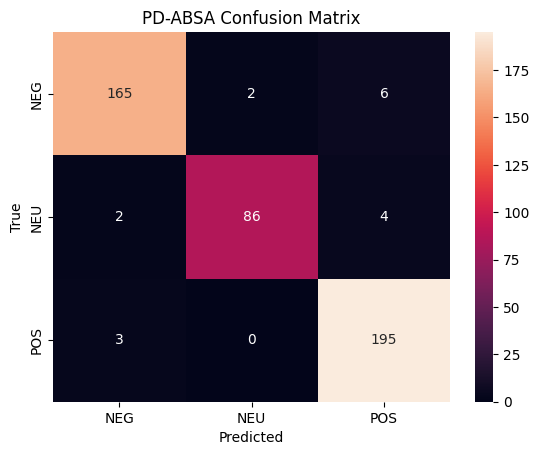

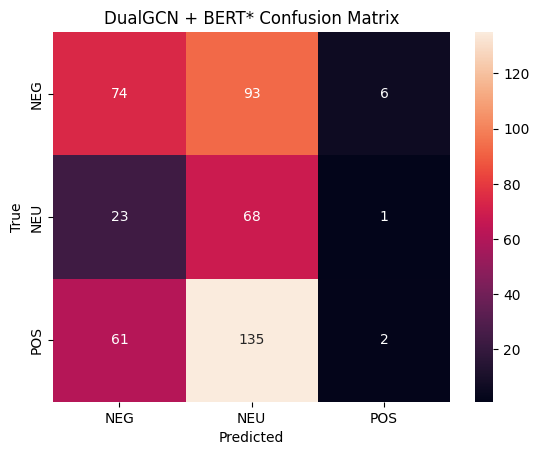

In [141]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=["NEG","NEU","POS"],
                yticklabels=["NEG","NEU","POS"])
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

plot_confusion(pd_labels, pd_preds, "PD-ABSA Confusion Matrix")
plot_confusion(dg_labels, dg_preds, "DualGCN + BERT* Confusion Matrix")


In [145]:
from sklearn.metrics import roc_auc_score

def get_probs_pd_absa(model, dataloader):
    model.eval()
    probs = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            logits = model(
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device)
            )  # shape [3]

            p = torch.softmax(logits, dim=-1).cpu().numpy()
            probs.append(p)
            labels.append(batch["label"].item())

    return np.array(labels), np.array(probs)
pd_y_true, pd_y_prob = get_probs_pd_absa(model, val_loader)

pd_auc = roc_auc_score(
    pd_y_true,
    pd_y_prob,
    multi_class="ovr",
    average="macro"
)

print("✅ PD-ABSA ROC–AUC (macro, OvR):", pd_auc)


✅ PD-ABSA ROC–AUC (macro, OvR): 0.9889040922008814


In [146]:
def get_probs_bert(model, dataloader):
    model.eval()
    probs = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            logits = model(
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device)
            )  # shape [B, 3]

            p = torch.softmax(logits, dim=-1).cpu().numpy()
            probs.append(p)
            labels.append(batch["label"].cpu().numpy())

    return np.concatenate(labels), np.concatenate(probs)
dg_y_true, dg_y_prob = get_probs_bert(baseline_model, bert_val_loader)

dg_auc = roc_auc_score(
    dg_y_true,
    dg_y_prob,
    multi_class="ovr",
    average="macro"
)

print("✅ DualGCN + BERT* ROC–AUC (macro, OvR):", dg_auc)


✅ DualGCN + BERT* ROC–AUC (macro, OvR): 0.535590176432453


In [147]:
auc_table = pd.DataFrame({
    "Model": ["PD-ABSA", "DualGCN + BERT*"],
    "ROC–AUC (Macro OvR)": [pd_auc, dg_auc]
})

auc_table


,Model,ROC–AUC (Macro OvR)
0,PD-ABSA,0.988904
1,DualGCN + BERT*,0.535590


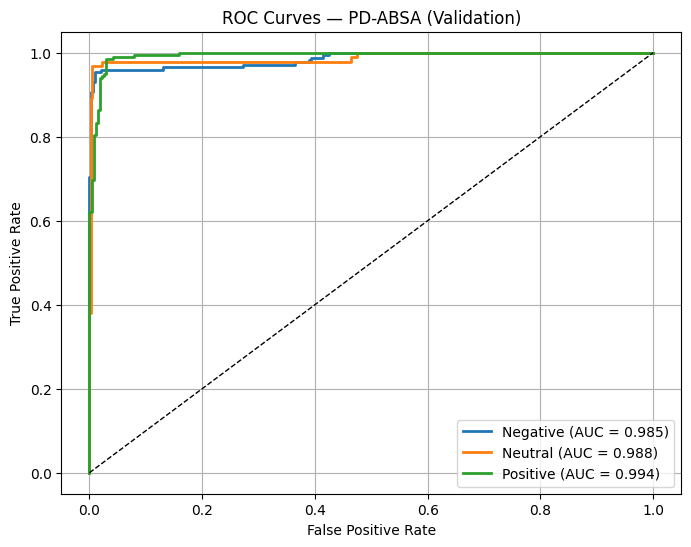

In [149]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

class_names = ["Negative", "Neutral", "Positive"]
n_classes = 3

def plot_roc_pd_absa(y_true, y_prob):
    # Binarize labels
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(
            fpr, tpr,
            lw=2,
            label=f"{class_names[i]} (AUC = {roc_auc:.3f})"
        )

    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves — PD-ABSA (Validation)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_roc_pd_absa(pd_y_true, pd_y_prob)

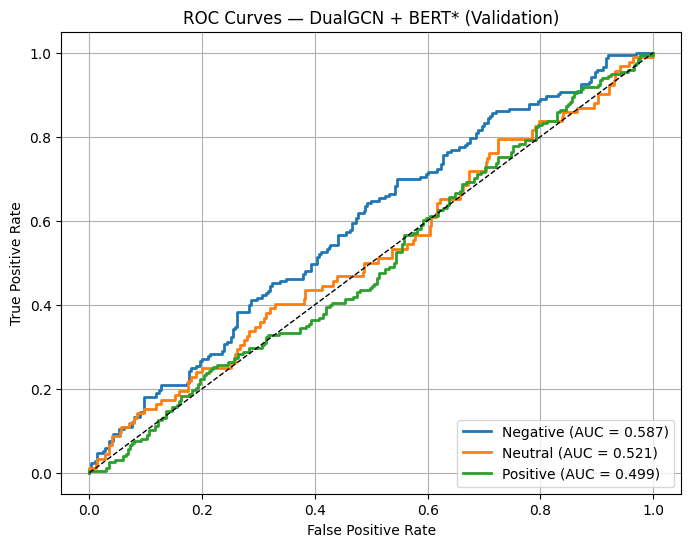

In [150]:
def plot_roc_baseline(y_true, y_prob):
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(
            fpr, tpr,
            lw=2,
            label=f"{class_names[i]} (AUC = {roc_auc:.3f})"
        )

    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves — DualGCN + BERT* (Validation)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

plot_roc_baseline(dg_y_true, dg_y_prob)